In [1]:
import sys
sys.path.append("./reference")
import torch as t
from reference.glide_text2im.download import load_checkpoint
from reference.glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
)

device = t.device('cpu')
options = model_and_diffusion_defaults()
options['timestep_respacing'] = '100'
ref_model, diffusion = create_model_and_diffusion(**options)
ref_model.load_state_dict(load_checkpoint('base', device))
from unet import Text2Im
from reference.glide_text2im.tokenizer.bpe import get_encoder
tokenizer = get_encoder()
model = Text2Im(tokenizer)
state = ref_model.state_dict()
mapped = {ours: state[theirs] for ours, theirs in zip(model.state_dict().keys(), ref_model.state_dict().keys())}
model.load_state_dict(mapped)

<All keys matched successfully>

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from PIL import Image
from IPython.display import display
import torch as th


In [4]:
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

In [5]:
# Sampling parameters
prompt = "an oil painting of a corgi"
batch_size = 1
guidance_scale = 3.0

# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.997

  0%|          | 0/100 [00:00<?, ?it/s]

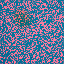

In [7]:
##############################
# Sample from the base model #
##############################

# Create the text tokens to feed to the model.
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, options['text_ctx']
)

# Create the classifier-free guidance tokens (empty)
full_batch_size = batch_size * 2
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
    [], options['text_ctx']
)

# Pack the tokens together into model kwargs.
model_kwargs = dict(
    tokens=th.tensor(
        [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size + [uncond_mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)

# Create a classifier-free guidance sampling function
def model_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)

# Sample from the base model.
model.del_cache()
samples = diffusion.p_sample_loop(
    model_fn,
    (full_batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model.del_cache()

# Show the output
show_images(samples)